# Searching for evidence of mass-dependent heating.

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Download Gaia catalog

In [4]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")
    
print(np.shape(gaia))

# Apply S/N cuts.
sn = gaia.parallax.values/gaia.parallax_error.values

m = (sn > 10) * (gaia.parallax.values > 0) * np.isfinite(gaia.parallax.values)
gaia = gaia.iloc[m]
print(np.shape(gaia))

(197090, 101)
(178729, 101)


Get extinction.

In [5]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 20.135 s
  pix_info:   0.467 s
   samples:   8.386 s
      best:   4.358 s
       nan:   0.199 s
      sort:   6.498 s
       idx:   0.226 s


In [8]:
coords = SkyCoord(gaia.ra.values*units.deg, gaia.dec.values*units.deg,
                  distance=(1./(gaia.parallax.values*1e-3))*units.pc)

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.], return_flags=True)

Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)

# Catch places where the extinction uncertainty is zero and default to an uncertainty of .05
m = Av_std == 0
Av_std[m] = .05

(178729, 101) (178729,)


In [9]:
gaia["ebv"] = ebv[:, 1]  # The median ebv value.
gaia["Av"] = Av
gaia["Av_errp"] = Av_errp
gaia["Av_errm"] = Av_errm
gaia["Av_std"] = Av_std

Calculate dereddened photometry.

In [11]:
from tools import getDust
    
AG, Abp, Arp = getDust(gaia.phot_g_mean_mag.values, gaia.phot_bp_mean_mag.values,
                       gaia.phot_rp_mean_mag.values, gaia.ebv.values)

In [12]:
gaia["bp_dered"] = gaia.phot_bp_mean_mag.values - Abp
gaia["rp_dered"] = gaia.phot_rp_mean_mag.values - Arp
gaia["bprp_dered"] = gaia["bp_dered"] - gaia["rp_dered"]
gaia["G_dered"] = gaia.phot_g_mean_mag.values - AG

def mM(m, D):
    return 5 - 5*np.log10(D) + m

abs_G = mM(gaia.G_dered.values, 1./(gaia.parallax.values*1e-3))
gaia["abs_G"] = abs_G

Remove nans.

In [14]:
m2 = np.isfinite(gaia.abs_G.values)

gaia_kep = gaia.iloc[m2]

Calculate photometric temperatures.

In [80]:
coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
          -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
          301.13205924630165, -25.923997443169355]
teffs = np.polyval(coeffs[::-1], gaia_kep.bp_dered - gaia_kep.rp_dered)
gaia_kep["color_teffs"] = teffs

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(2000, 10000)

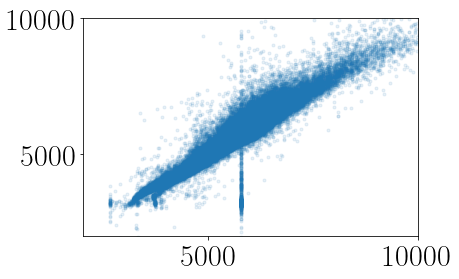

In [85]:
plt.plot(gaia_kep.teff, gaia_kep.color_teffs, ".", alpha=.1)
plt.xlim(2000, 10000)
plt.ylim(2000, 10000)

Plot CMD

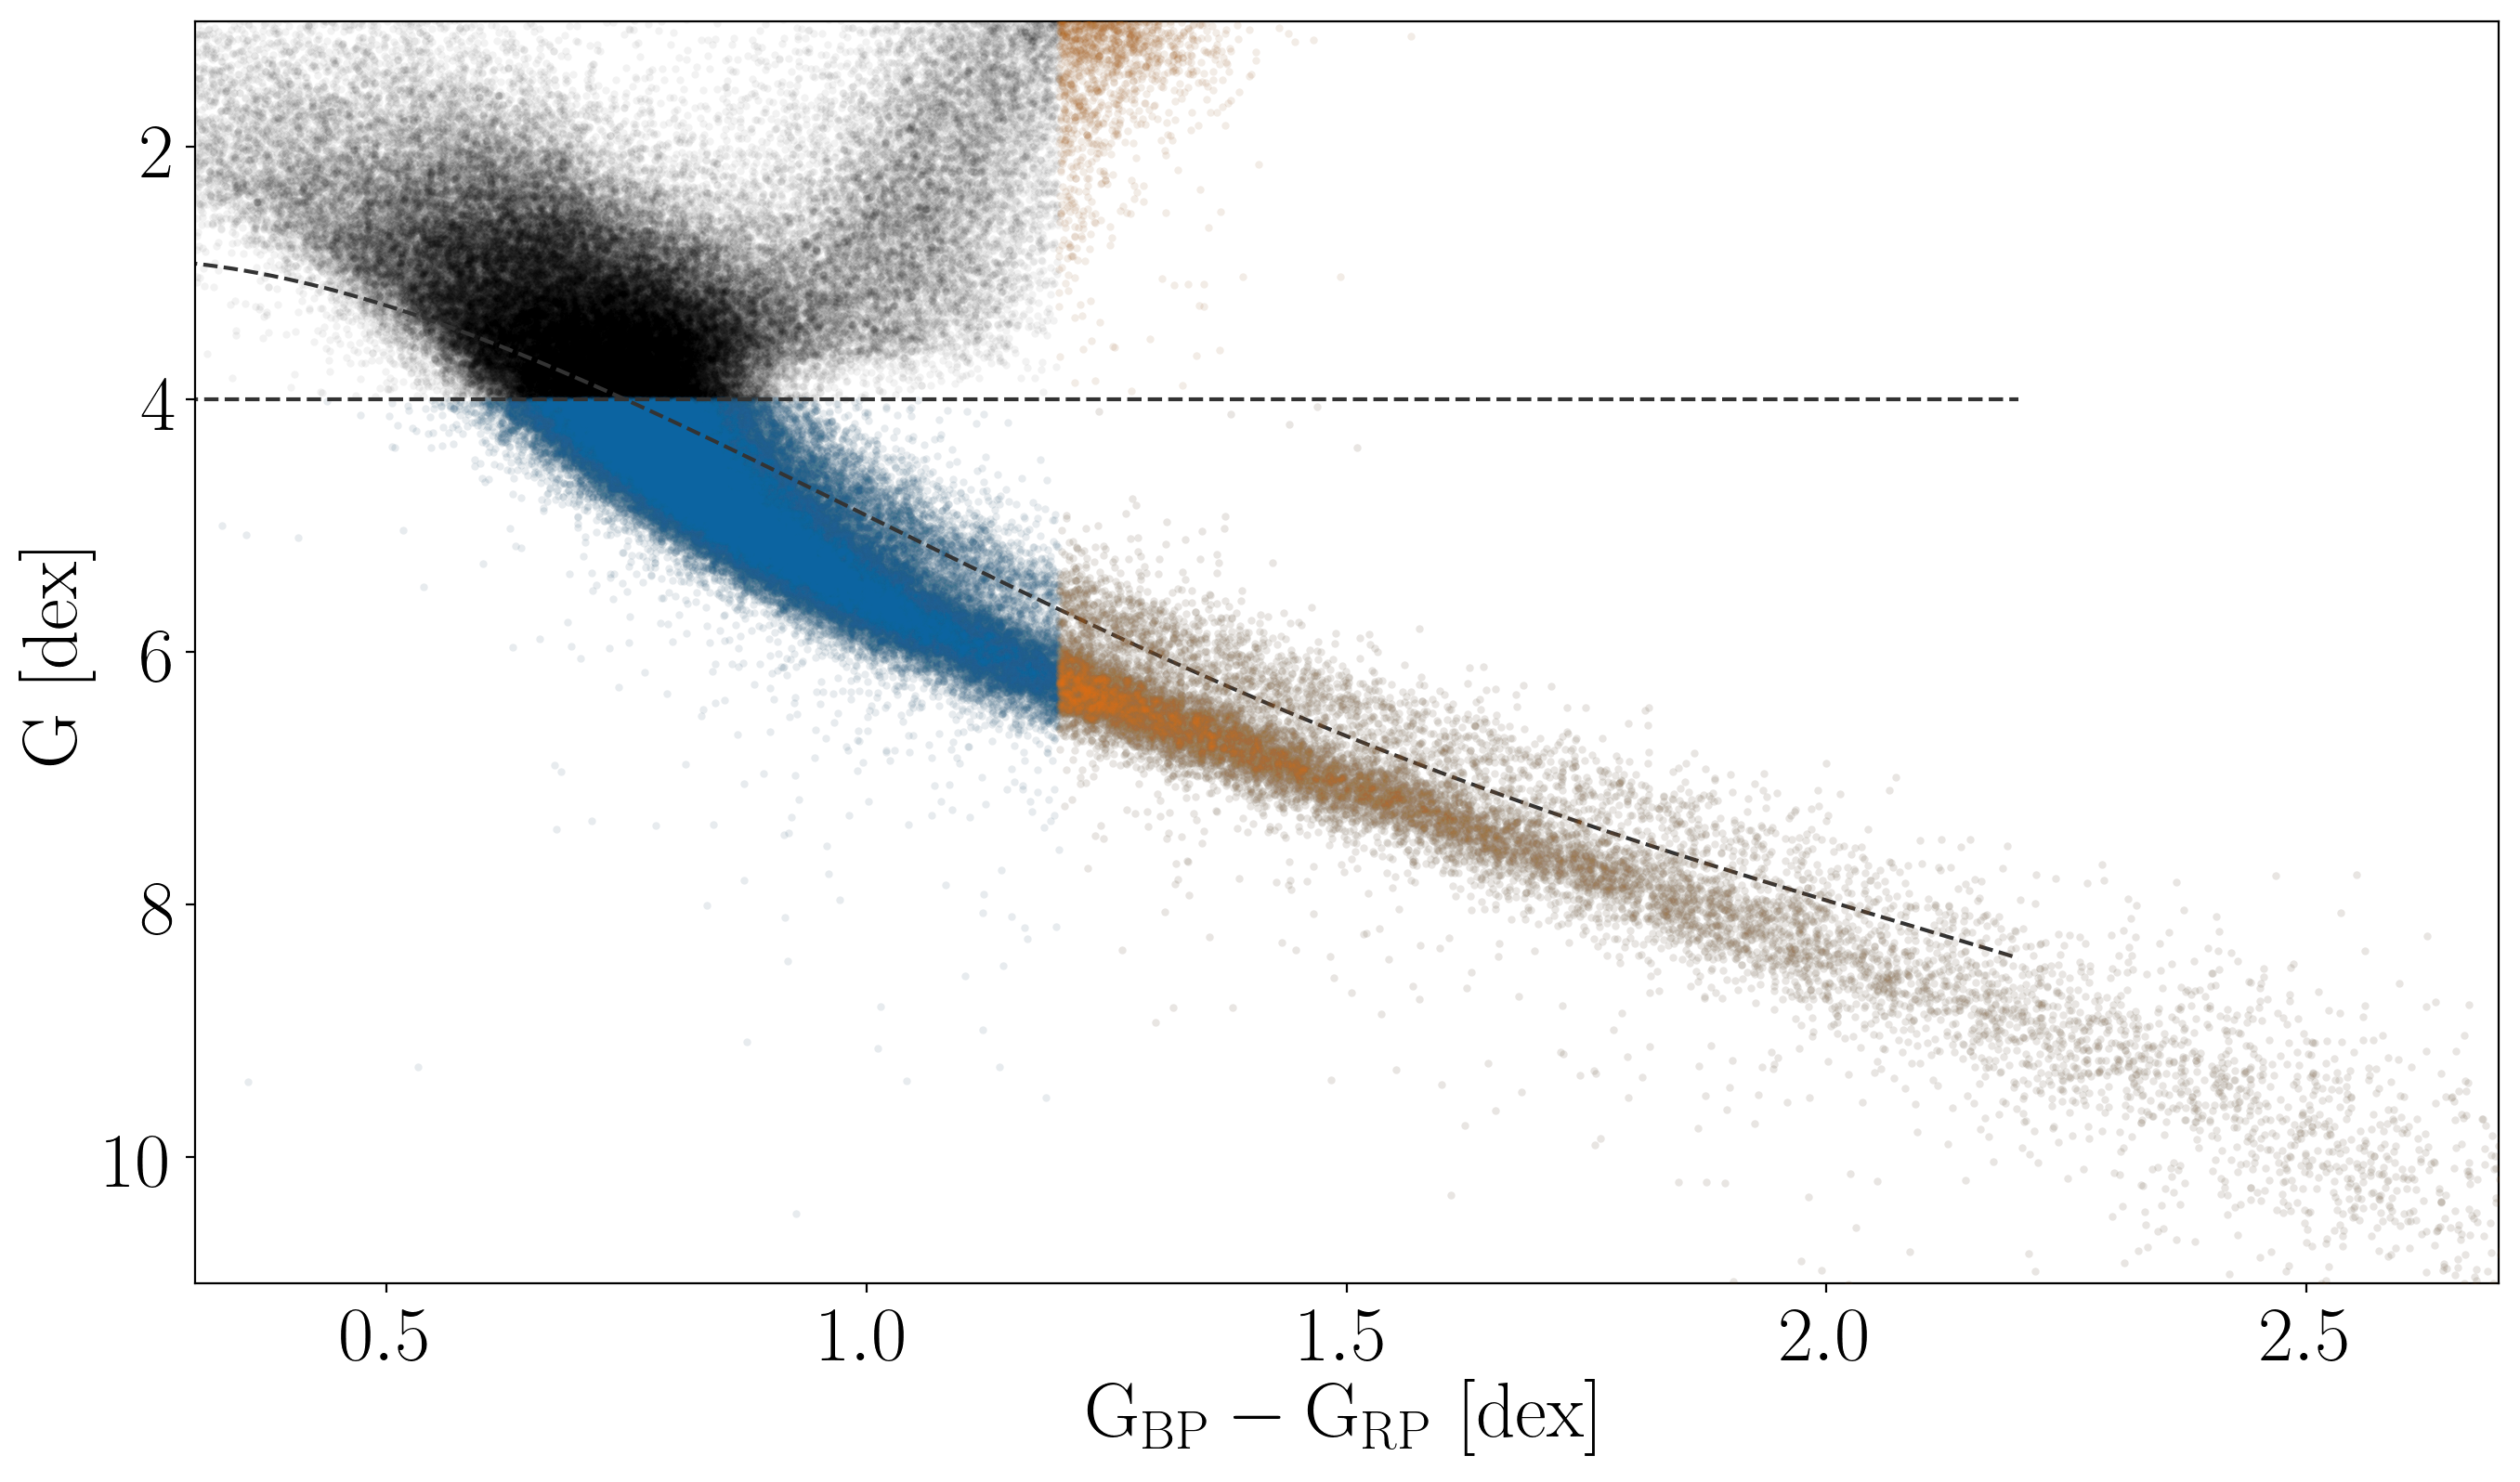

In [135]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gaia_kep.bp_dered - gaia_kep.rp_dered, gaia_kep.abs_G,
         "k.", alpha=.05, mec="none", rasterized=True, zorder=0)
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.ylim(11, 1)
plt.xlim(.3, 2.7);

subcut = 4
colorcut = 1.2
mcolor = (gaia_kep.bp_dered - gaia_kep.rp_dered) > colorcut
m = gaia_kep.abs_G.values > subcut

x = gaia_kep.bp_dered[m] - gaia_kep.rp_dered[m]
y = gaia_kep.abs_G[m]
plt.plot(x, y, ".", alpha=.05, rasterized=True, zorder=1, mec="none")

w = np.polyfit(x, y, 6)

minb, maxb, extra = 0, 2.2, .4
xs = np.linspace(minb, maxb, 1000)
plt.plot(xs, np.polyval(w, xs) - extra, "--", color=".2")
plt.plot(xs, np.ones_like(xs)*subcut, "--", color=".2")

plt.plot(gaia_kep.bp_dered.values[mcolor] - gaia_kep.rp_dered.values[mcolor], gaia_kep.abs_G.values[mcolor],
         "C1.", alpha=.05, rasterized=True, zorder=3, mec="none")

In [136]:
m = (minb < gaia_kep.bp_dered - gaia_kep.rp_dered) * (gaia_kep.bp_dered - gaia_kep.rp_dered < maxb)
m &= (gaia_kep.abs_G < np.polyval(w, gaia_kep.bp_dered - gaia_kep.rp_dered) - extra) \
    + (subcut > gaia_kep.abs_G)

flag = np.zeros(len(gaia_kep))
flag[~m] = np.ones(len(flag[~m])) 
gaia_kep["flag"] = flag

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Just look at M dwarfs

In [273]:
# Cut out visual binaries and subgiants
dwarfs = gaia_kep.iloc[gaia_kep.flag.values == 1]
m = dwarfs.bp_dered.values - dwarfs.rp_dered.values > colorcut
mdwarfs = dwarfs.iloc[m]

Text(0, 0.5, '$\\mathrm{G~[dex]}$')

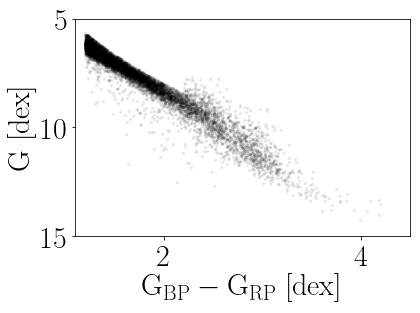

In [274]:
plt.plot(mdwarfs.bp_dered - mdwarfs.rp_dered, mdwarfs.abs_G, "k.", alpha=.1, mec="none")
plt.ylim(15, 5)
plt.xlim(colorcut-.1, 4.5);
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")

Calculate velocities

In [275]:
from calc_velocities import calc_vb

pmb_samples, vb_samples = calc_vb(mdwarfs)

In [276]:
pmb, vb = np.median(pmb_samples, axis=1), np.median(vb_samples, axis=1)
pmb_err, vb_err = np.std(pmb_samples, axis=1), np.std(vb_samples, axis=1)
pmb_errp = np.percentile(pmb_samples, 84, axis=1) - pmb
pmb_errm = pmb - np.percentile(pmb_samples, 16, axis=1)
vb_errp = np.percentile(vb_samples, 84, axis=1) - vb
vb_errm = vb - np.percentile(vb_samples, 16, axis=1)

mdwarfs["vb"] = vb
mdwarfs["vb_err"] = vb_err

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(0, 2)

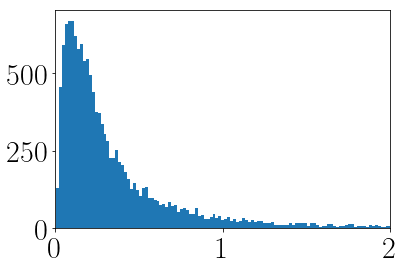

In [277]:
plt.hist(vb_err, 1000);
plt.xlim(0, 2)

Drop large errorbars.

In [282]:
print(np.shape(mdwarfs))
m = mdwarfs.vb_err.values < 1
mdwarfs2 = mdwarfs.iloc[m]
print(np.shape(mdwarfs2))

(13290, 115)
(12355, 115)


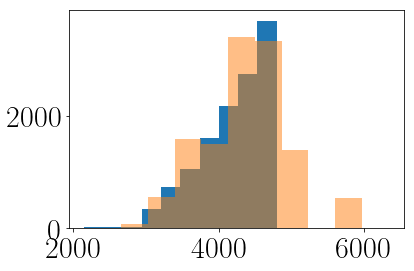

In [285]:
m = mdwarfs2.color_teffs.values > 2000
mdwarfs2 = mdwarfs2.iloc[m]
plt.hist(mdwarfs2.color_teffs);
plt.hist(mdwarfs2.teff, alpha=.5);

In [286]:
teff_bins = np.linspace(3000, max(mdwarfs2.color_teffs), 12)
teff_masks = select_stars(mdwarfs2, teff_bins, "color_teffs")
mid_teff_bin = np.diff(teff_bins)*.5 + teff_bins[:-1]

mdwarfs2["bprp"] = mdwarfs2.bp_dered.values - mdwarfs2.rp_dered.values
color_bins = np.linspace(min(mdwarfs2.bprp.values), 4, 12)
mid_color_bin = np.diff(color_bins)*.5 + color_bins[:-1]
color_masks = select_stars(mdwarfs2, color_bins, "bprp")

niter =  4 72 stars removed kurtosis =  0.1361712113176048
niter =  5 40 stars removed kurtosis =  0.32060676899877283
niter =  5 31 stars removed kurtosis =  0.22178415396898865
niter =  5 16 stars removed kurtosis =  0.2889576804757761
niter =  6 24 stars removed kurtosis =  0.5379240955014981
niter =  4 15 stars removed kurtosis =  0.4644506495866607
niter =  3 8 stars removed kurtosis =  0.47772004343913155
niter =  2 2 stars removed kurtosis =  0.7010733996222962
niter =  3 2 stars removed kurtosis =  -0.49382583548753356
niter =  1 0 stars removed kurtosis =  -0.8209921107873535
niter =  0 0 stars removed kurtosis =  nan


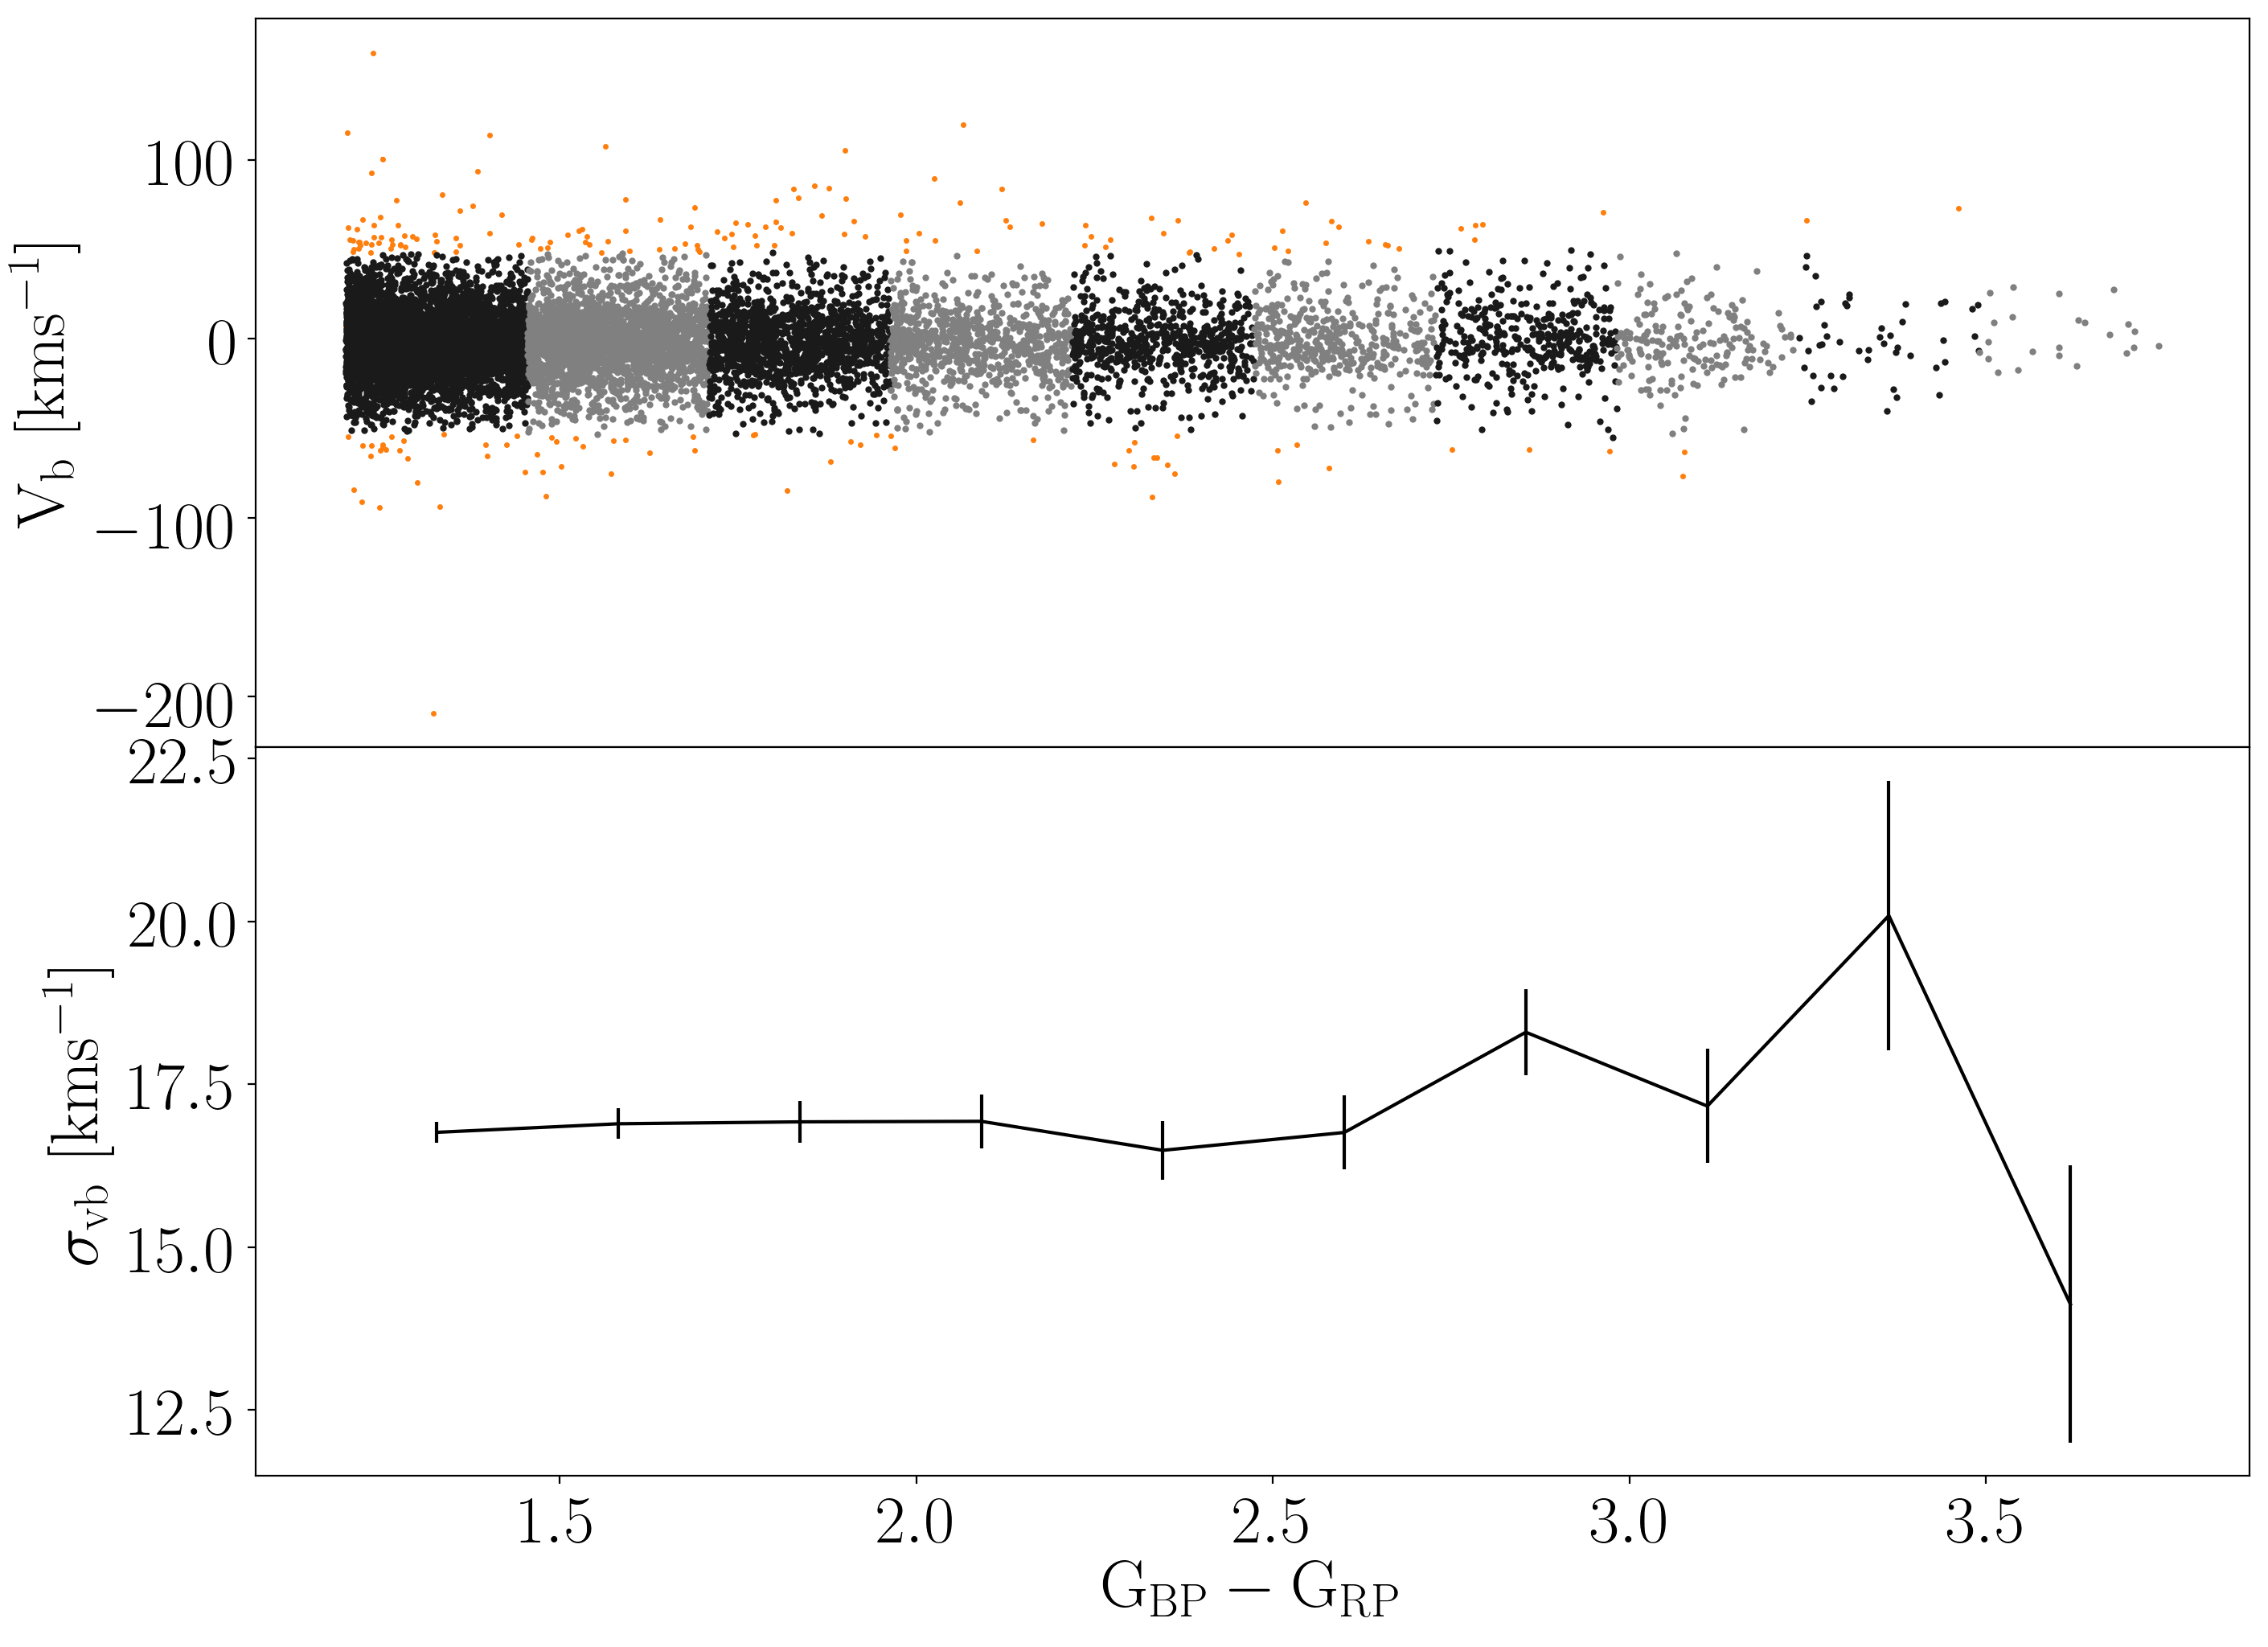

In [331]:
fig = plt.figure(figsize=(16, 12), dpi=200)

# Top panel
ax1 = fig.add_subplot(211)
ax1.errorbar(mdwarfs2.bprp, mdwarfs2.vb, yerr=mdwarfs2.vb_err, fmt="C1.", ms=3, rasterized=True)

greys = [".1", ".5"]
sigma_vb, sigma_vb_err = [], []
for i, m in enumerate(color_masks):
    v_clipped, clipping_mask = sigma_clip(mdwarfs2.vb.values[m], 3)
    sigma_vb.append(np.std(v_clipped))
    sigma_vb_err.append(err_on_sample_std_dev(np.std(v_clipped), float(len(v_clipped))))
    ax1.errorbar(mdwarfs2.bprp[m][clipping_mask], mdwarfs2.vb[m][clipping_mask],
                 yerr=mdwarfs2.vb_err[m][clipping_mask],
                 fmt=".", mec="none", color=greys[i % 2])
ax1.set_ylabel("$\mathrm{V_b~[kms^{-1}]}$")
    
# Bottom panel
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.errorbar(mid_color_bin, sigma_vb, yerr=sigma_vb_err, fmt="k")
# plt.ylim(17, 22)
# plt.xlim(1.2, 3.5)
ax2.set_xlabel("$\mathrm{G_{BP}-G_{RP}}$")
ax2.set_ylabel("$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
plt.subplots_adjust(hspace=0)
plt.savefig("paper/vb_vs_teff.pdf")

niter =  2 3 stars removed kurtosis =  0.23457706430736103
niter =  3 8 stars removed kurtosis =  0.4979001045972504
niter =  4 15 stars removed kurtosis =  0.46886476266022825
niter =  6 24 stars removed kurtosis =  0.5805786361299812
niter =  4 13 stars removed kurtosis =  0.33087380119330234
niter =  5 24 stars removed kurtosis =  0.24125435293976016
niter =  5 23 stars removed kurtosis =  0.2213631591556191
niter =  4 19 stars removed kurtosis =  0.28087726727689866
niter =  5 21 stars removed kurtosis =  0.32844017803021863
niter =  3 13 stars removed kurtosis =  0.16821176670525828
niter =  4 45 stars removed kurtosis =  0.06839855719038601


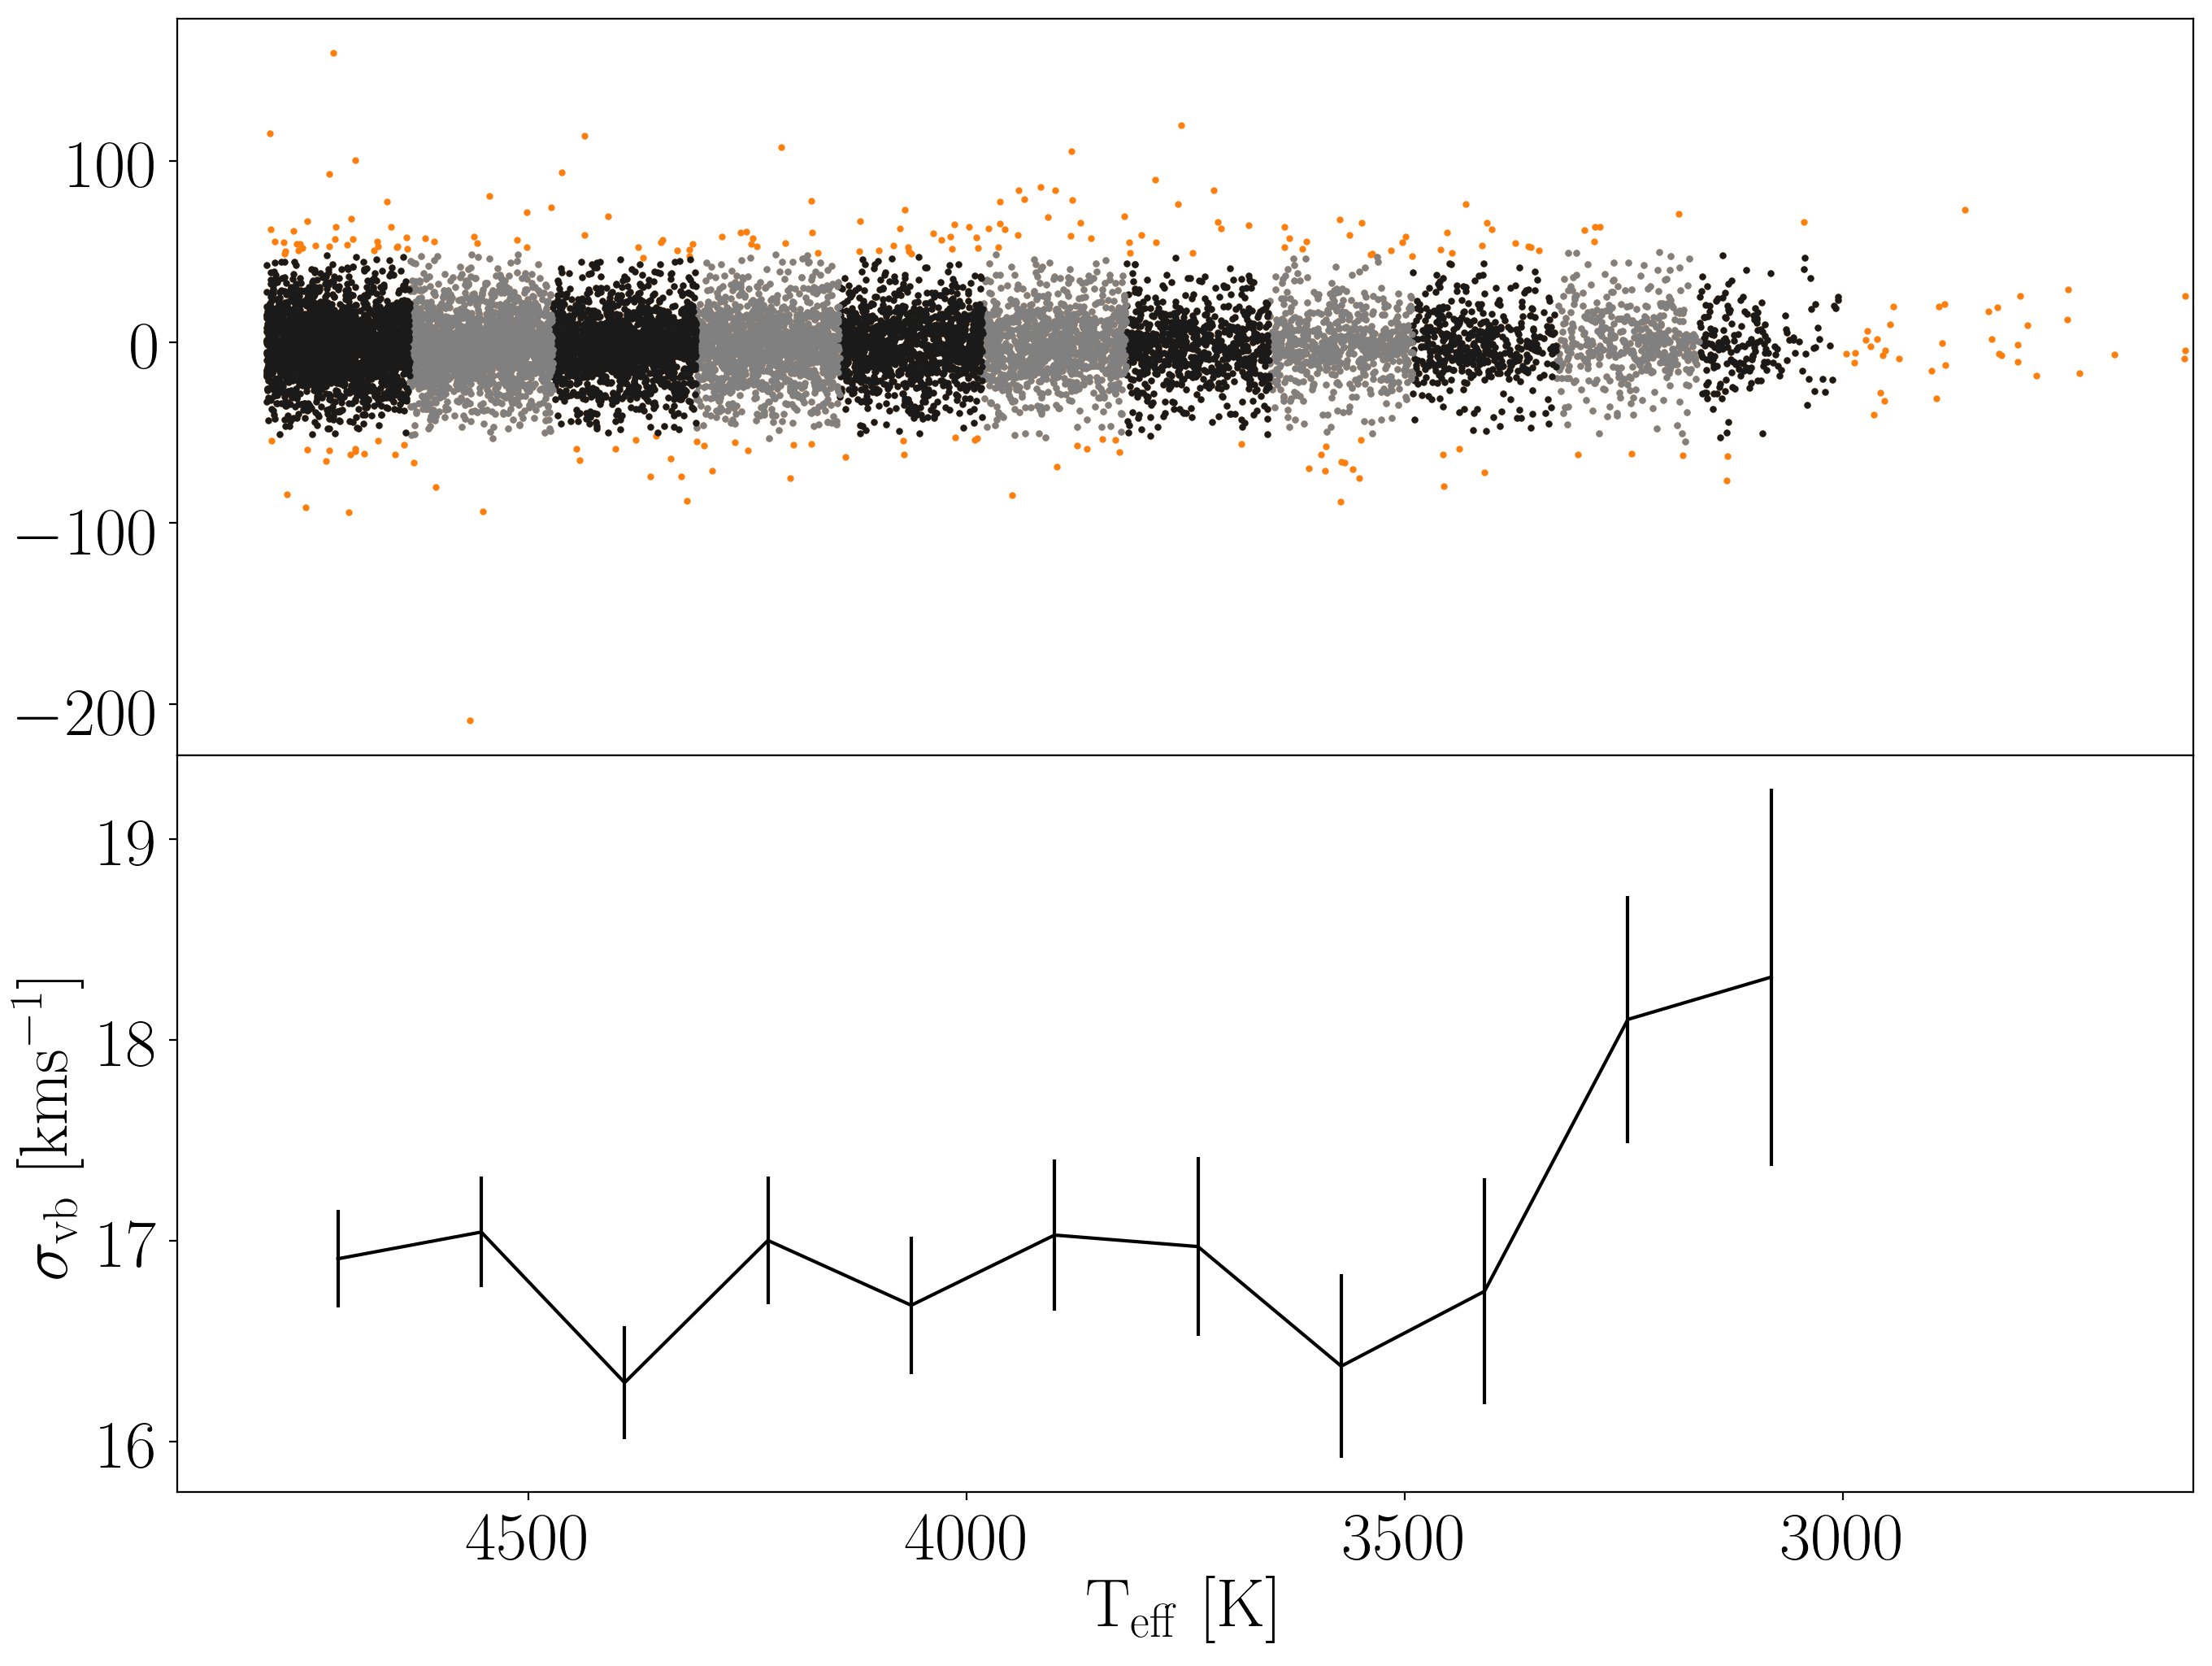

In [335]:
fig = plt.figure(figsize=(16, 12), dpi=200)

# Top panel
ax1 = fig.add_subplot(211)
ax1.errorbar(mdwarfs2.color_teffs, mdwarfs2.vb, yerr=mdwarfs2.vb_err, fmt="C1.", mec="none")
ax1.set_xlim(4900, 2600)

sigma_vb, sigma_vb_err = [], []
for i, m in enumerate(teff_masks):
    v_clipped, clipping_mask = sigma_clip(mdwarfs2.vb.values[m], 3)
    sigma_vb.append(np.std(v_clipped))
    sigma_vb_err.append(err_on_sample_std_dev(np.std(v_clipped), float(len(v_clipped))))
    ax1.errorbar(mdwarfs2.color_teffs[m][clipping_mask], mdwarfs2.vb[m][clipping_mask],
                 yerr=mdwarfs2.vb_err[m][clipping_mask],
                 fmt=".", mec="none", color=greys[i % 2])

    
# Bottom panel
ax2 = fig.add_subplot(212, sharex=ax1)

ax2.errorbar(mid_teff_bin, sigma_vb, yerr=sigma_vb_err, fmt="k")
# ax2.xlim(max(mid_teff_bin)+100, min(mid_teff_bin)-100)

ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
plt.subplots_adjust(hspace=0)
plt.savefig("paper/vb_vs_color.pdf")

(4900, 2600)

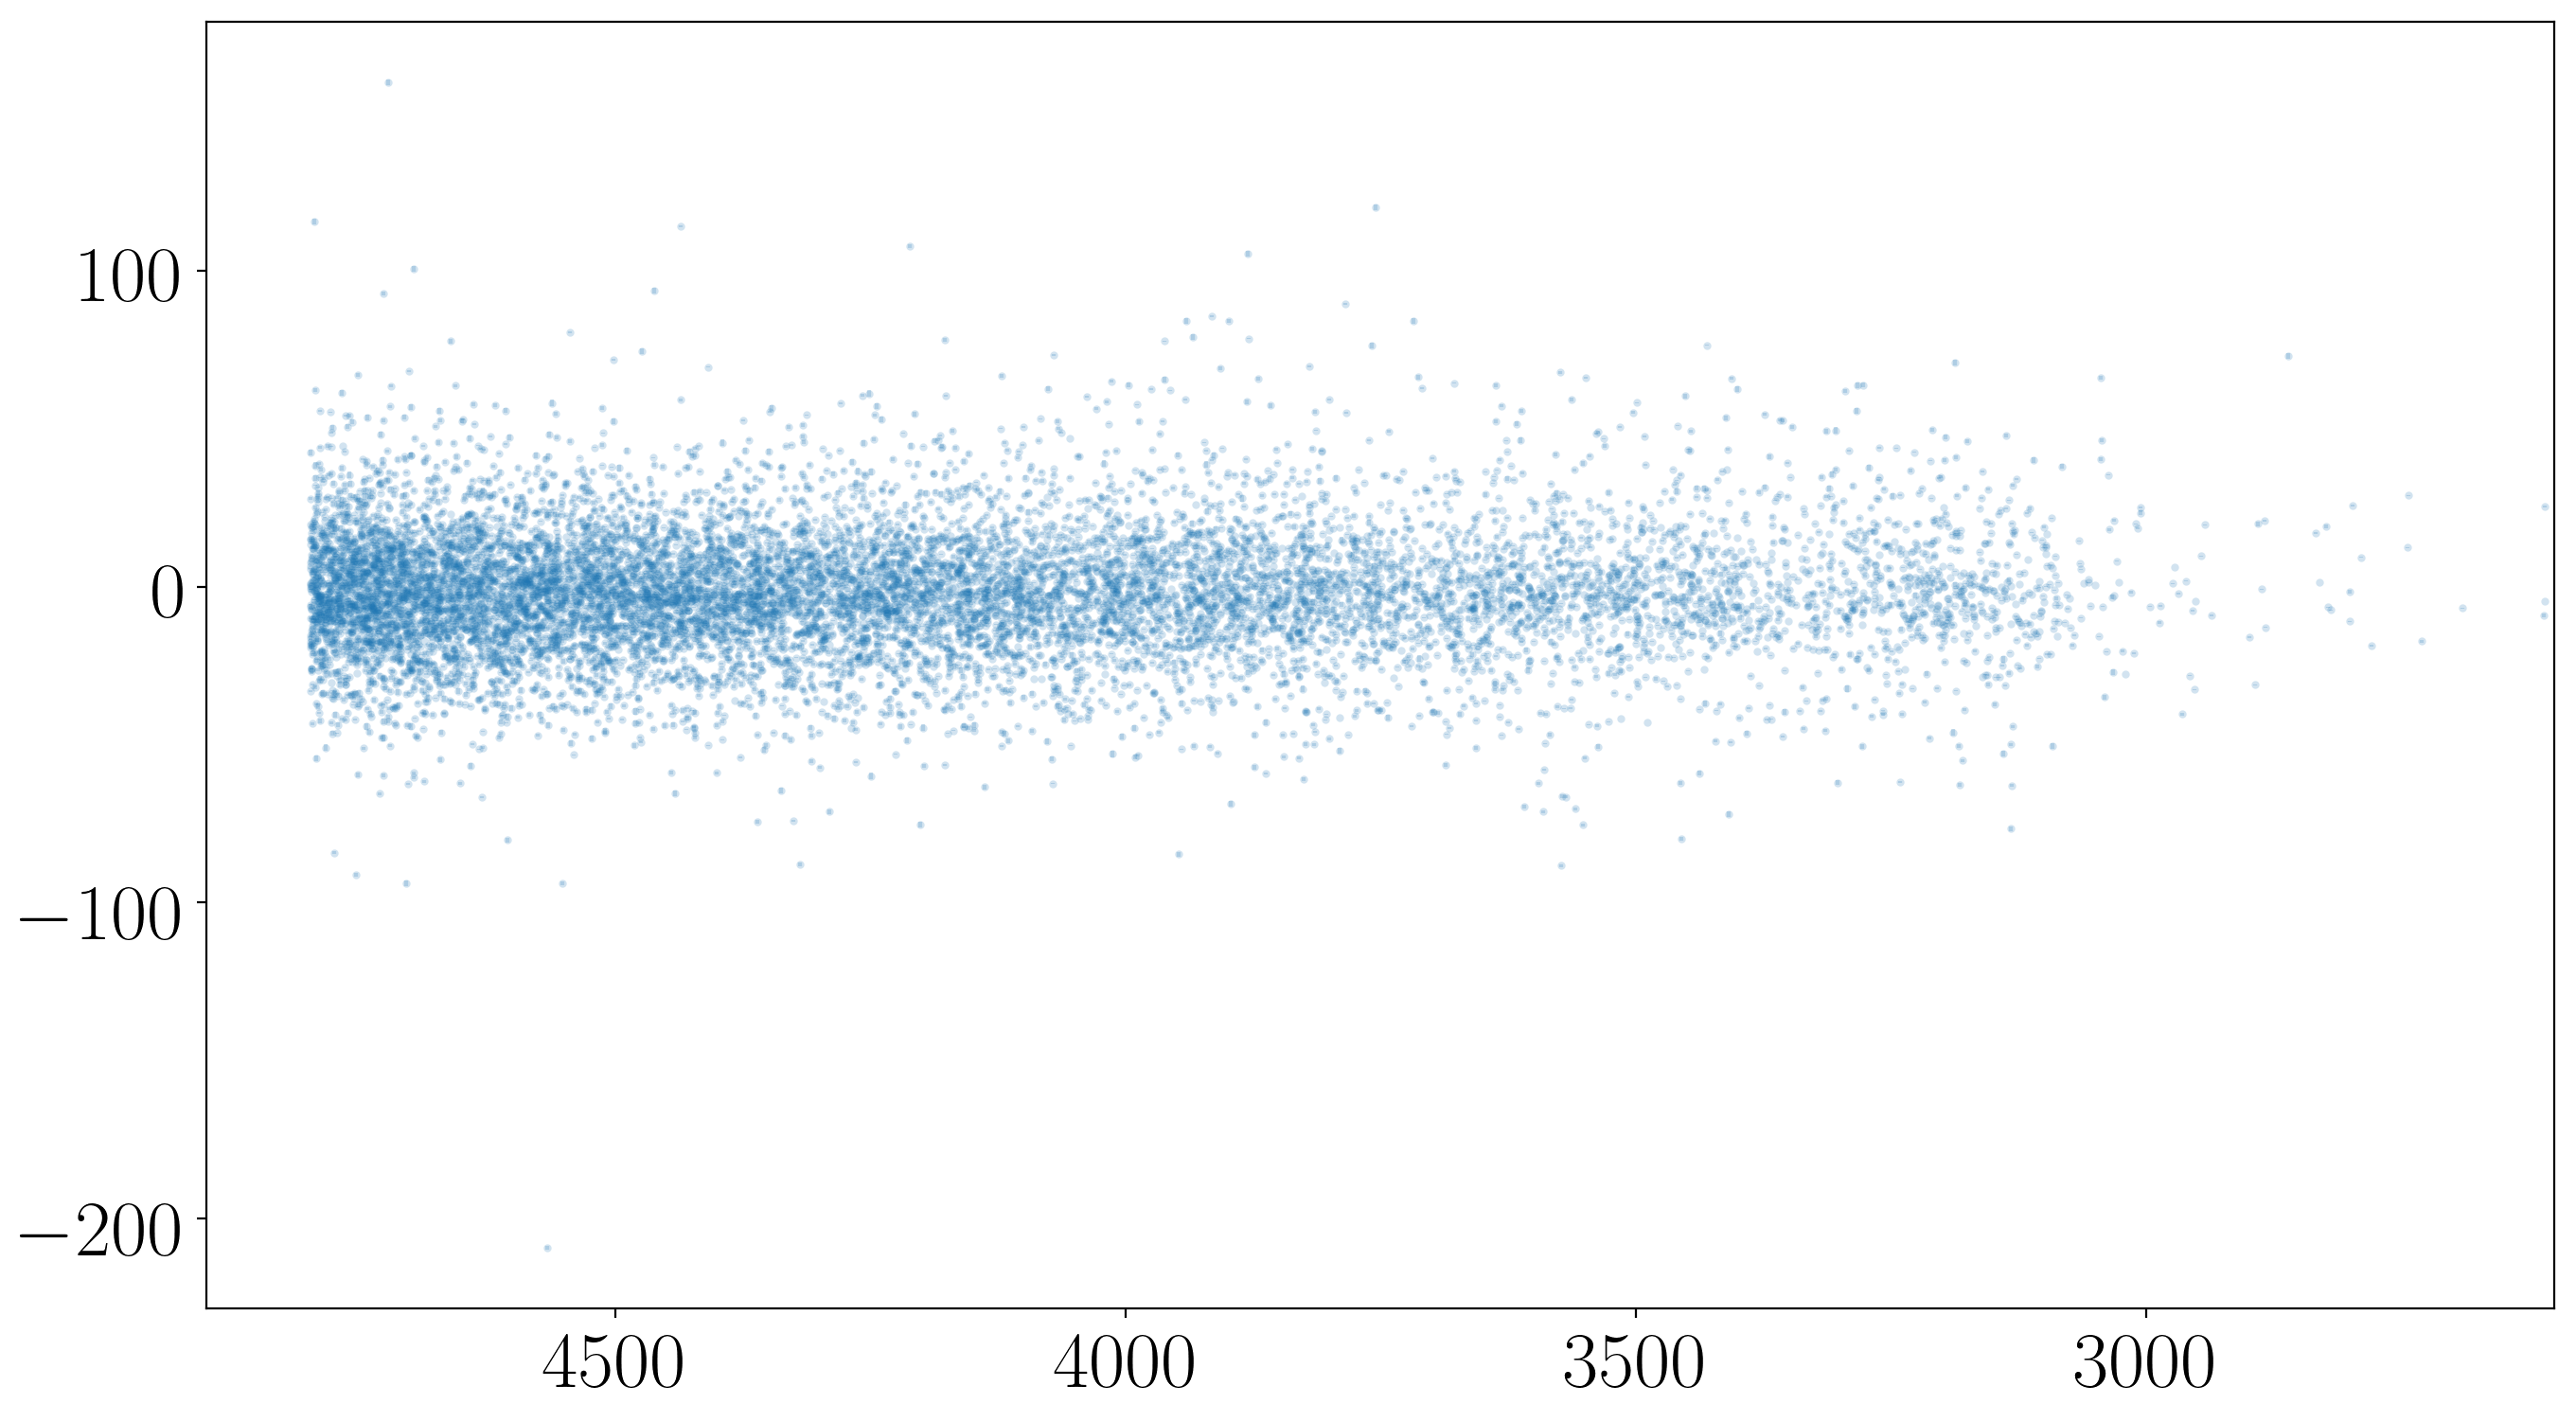

In [296]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(mdwarfs2.color_teffs, mdwarfs2.vb, yerr=mdwarfs2.vb_err, fmt=".", alpha=.2, mec="none")
plt.xlim(4900, 2600)

(2000, 6000)

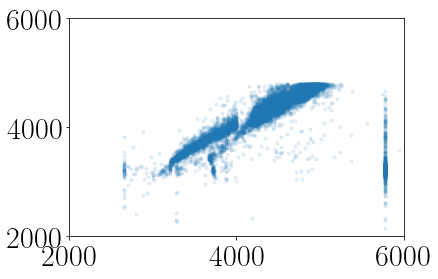

In [220]:
plt.plot(mdwarfs.teff, mdwarfs.color_teffs, ".", alpha=.1)
plt.xlim(2000, 6000)
plt.ylim(2000, 6000)